In [14]:
import os
import re
import tensorflow as tf
import numpy as np
import pandas as pd
import pymysql
import sys
from tqdm import tqdm
from waymo_open_dataset import dataset_pb2 as open_dataset

from waymo_open_dataset.utils import range_image_utils
from waymo_open_dataset.utils import transform_utils
from waymo_open_dataset.utils import  frame_utils
from os import close
import pymysql
import sqlalchemy
from sqlalchemy import create_engine
import sys

In [15]:
FILENAME = '/home/PJLAB/weixingjian/shared_data/training/segment-175830748773502782_1580_000_1600_000_with_camera_labels.tfrecord'


In [16]:
dataset = tf.data.TFRecordDataset(FILENAME, compression_type='')
count = 0
# pbar = tqdm(total=199)
for data in dataset:
    frame = open_dataset.Frame()
    frame.ParseFromString(bytearray(data.numpy()))
    break
    # if count == 0:

In [17]:
(range_images, 
 camera_projections,
 range_image_top_pose) = frame_utils.parse_range_image_and_camera_projection(frame)
 
points, cp_points = frame_utils.convert_range_image_to_point_cloud(
    frame,
    range_images,
    camera_projections,
    range_image_top_pose)

points_ri2, cp_points_ri2 = frame_utils.convert_range_image_to_point_cloud(
    frame,
    range_images,
    camera_projections,
    range_image_top_pose,
    ri_index=1)

# 3d points in vehicle frame.
points_all = np.concatenate(points, axis=0)
points_all_ri2 = np.concatenate(points_ri2, axis=0)
# camera projection corresponding to each point.
cp_points_all = np.concatenate(cp_points, axis=0)
cp_points_all_ri2 = np.concatenate(cp_points_ri2, axis=0)

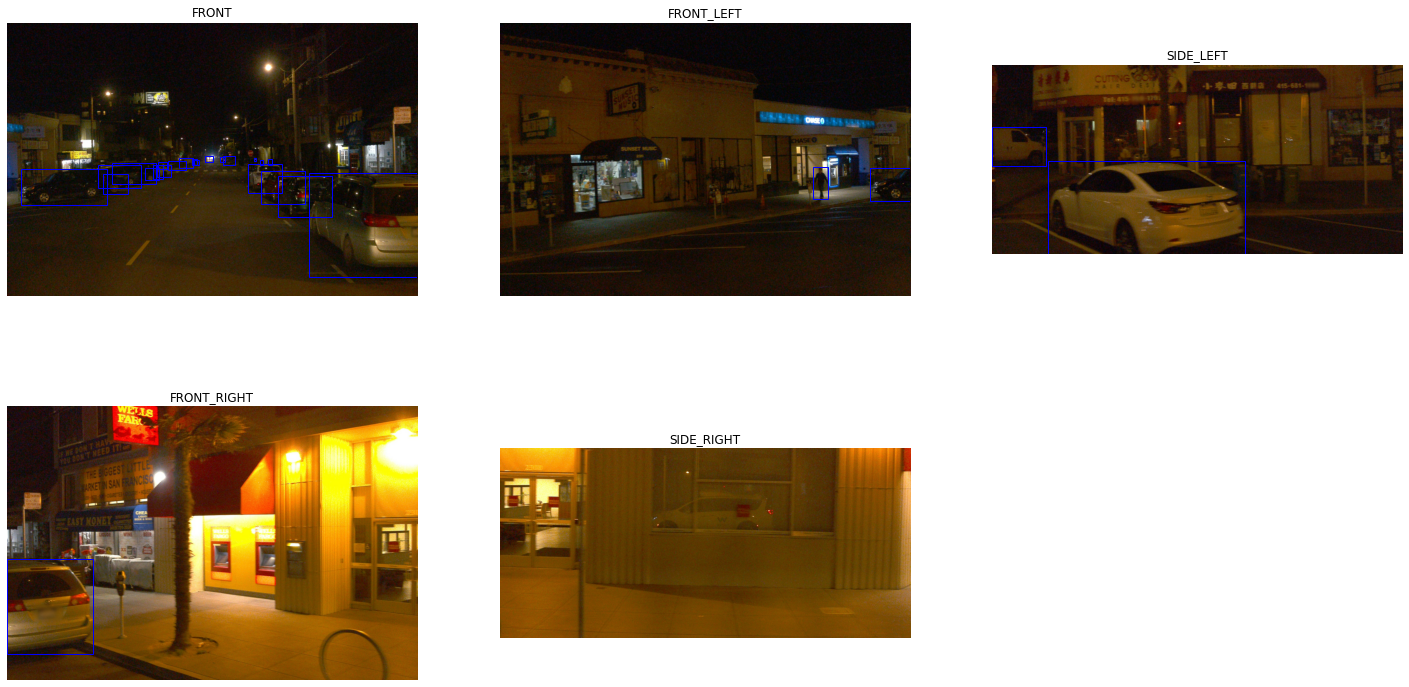

In [22]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_camera_image(camera_image, camera_labels, layout, cmap=None):
  """Show a camera image and the given camera labels."""

  ax = plt.subplot(*layout)

  # Draw the camera labels.
  for camera_labels in frame.camera_labels:
    # Ignore camera labels that do not correspond to this camera.
    if camera_labels.name != camera_image.name:
      continue

    # Iterate over the individual labels.
    for label in camera_labels.labels:
      # Draw the object bounding box.
      ax.add_patch(patches.Rectangle(
        xy=(label.box.center_x - 0.5 * label.box.length,
            label.box.center_y - 0.5 * label.box.width),
        width=label.box.length,
        height=label.box.width,
        linewidth=1,
        edgecolor='red',
        facecolor='none'))

  # Show the camera image.
  plt.imshow(tf.image.decode_jpeg(camera_image.image), cmap=cmap)
  plt.title(open_dataset.CameraName.Name.Name(camera_image.name))
  plt.grid(False)
  plt.axis('off')

plt.figure(figsize=(25, 20))

for index, image in enumerate(frame.images):
  show_camera_image(image, frame.camera_labels, [3, 3, index+1])

In [19]:
images = sorted(frame.images, key=lambda i:i.name)
cp_points_all_concat = np.concatenate([cp_points_all, points_all], axis=-1)
cp_points_all_concat_tensor = tf.constant(cp_points_all_concat)

# The distance between lidar points and vehicle frame origin.
points_all_tensor = tf.norm(points_all, axis=-1, keepdims=True)
cp_points_all_tensor = tf.constant(cp_points_all, dtype=tf.int32)

mask = tf.equal(cp_points_all_tensor[..., 0], images[0].name)

cp_points_all_tensor = tf.cast(tf.gather_nd(
    cp_points_all_tensor, tf.where(mask)), dtype=tf.float32)
points_all_tensor = tf.gather_nd(points_all_tensor, tf.where(mask))

projected_points_all_from_raw_data = tf.concat(
    [cp_points_all_tensor[..., 1:3], points_all_tensor], axis=-1).numpy()

In [25]:
def rgba(r):
    """Generates a color based on range.

    Args:
    r: the range value of a given point.
    Returns:
    The color for a given range
    """
    c = plt.get_cmap('jet')((r % 20.0) / 20.0)
    c = list(c)
    c[-1] = 0.5  # alpha
    return c

def plot_image(camera_image):
  """Plot a cmaera image."""
  plt.figure(figsize=(20, 12))
  plt.imshow(tf.image.decode_jpeg(camera_image.image))
  plt.grid("off")

def plot_points_on_image(projected_points, camera_image, rgba_func,
                         point_size=5.0):
  """Plots points on a camera image.

  Args:
    projected_points: [N, 3] numpy array. The inner dims are
      [camera_x, camera_y, range].
    camera_image: jpeg encoded camera image.
    rgba_func: a function that generates a color from a range value.
    point_size: the point size.

  """
  plot_image(camera_image)

  xs = []
  ys = []
  colors = []

  for point in projected_points:
    xs.append(point[0])  # width, col
    ys.append(point[1])  # height, row
    colors.append(rgba_func(point[2]))

  plt.scatter(xs, ys, c=colors, s=point_size, edgecolors="None")

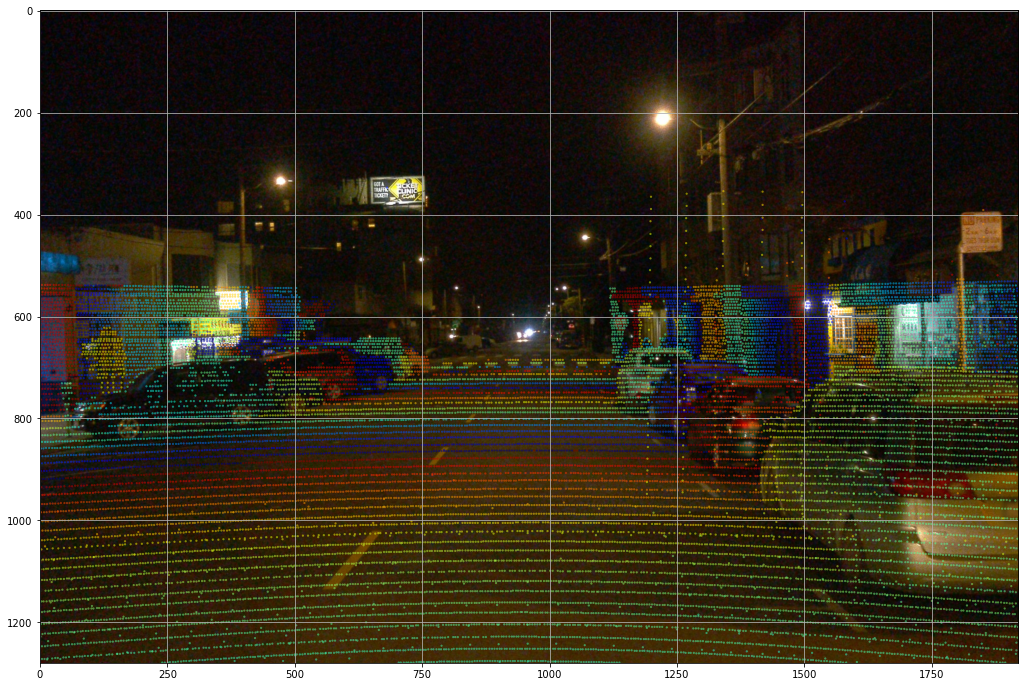

In [26]:
plot_points_on_image(projected_points_all_from_raw_data,
                     images[0], rgba, point_size=5.0)

In [30]:
frame.laser_labels

[box {
  center_x: 13.383917924723391
  center_y: 11.24075894158159
  center_z: 0.49413428166462836
  width: 0.3152416349217722
  length: 0.05851497100714059
  height: 0.4600000000000364
  heading: -1.6337592500080091
}
metadata {
  speed_x: 0.11751156592577955
  speed_y: 0.07596801864215764
  accel_x: -0.16991114987904504
  accel_y: 0.004619920644672597
}
type: TYPE_SIGN
id: "1C92rUDVJrUsUIwjSJ8qMQ"
num_lidar_points_in_box: 15
, box {
  center_x: 13.714587509822195
  center_y: -5.3029245768157125
  center_z: 3.3163314501348395
  width: 0.43556812276149565
  length: 0.050223182289440886
  height: 0.4808259587023258
  heading: 3.1151431200905275
}
metadata {
  speed_x: -0.0023533262109087755
  speed_y: 0.009879407243045181
  accel_x: -1.770849830416752e-13
  accel_y: 2.394028642785278e-12
}
type: TYPE_SIGN
id: "2rGIozK-TUqB8zk0Q830YQ"
num_lidar_points_in_box: 2
, box {
  center_x: 66.06361572079368
  center_y: -7.093097509126892
  center_z: 1.4768865882506361
  width: 0.9199097337911694